# SOC LEAFs Forest Supporting calculations
This notebook documents the generation of forest base data needed to run RothC model and serves as a complement to [SOC_LEAFs_Baseline](../documentation/SOC_LEAFs_Baseline.ipynb) notebook.

## Step 1 - Data Preparation
### 1) Litter
As land use has already been determined, the next step is to estimate litter production annually. Litter production is estimated in two periods: a) growing and b) mature. [IPCC 2003](https://www.ipcc-nggip.iges.or.jp/public/gpglulucf/gpglulucf_files/Chp3/Chp3_2_Forest_Land.pdf) provides residue production $\small (RES_{maturity})$ on maturity on Table 3.2.1, which is used here, as well as time to reach maturity (transition period or TP) for Broadleaf and Needleleaf forest in different thermal zones. Litter production during the growing period is assumed to grow linearly from 0 till maturity, and thus can be calculated as:
$$ I_{t} = \min(RES_{maturity}, RES_{maturity}/TP\cdot(t)) $$

Where $t$ is the age of the forest.

Litter production values from table 3.2.1 has been summarized in [forest_residues_IPCC](../data/forest/forest_residues_IPCC.xlsx) excel spreadsheet.

#### 1.2) Forest age
To estimate forest age in accordance with Soil Grids SOC baseline, the [Global Forest Age Dataset (GFAD)](https://research.wur.nl/en/datasets/the-global-forest-age-dataset-and-its-uncertainties-gfadv11) v1.1 is used. This dataset assigns the fraction of each grid cell to an age band (1-10, 11-20, ... 141-150) for 4 different forest types: Broadleaf Deciduous, Broadleaf Evergreen, Needleleaf Deciduous, and Needleleaf Evergreen.

Loading the data...

In [1]:
# modules
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import rioxarray
import rasterio
from rasterio.enums import Resampling
import sbtn_leaf.map_plotting as mp
import polars as pl
import geopandas as gpd
import sbtn_leaf.cropcalcs as cropcalcs

Could not determine dtype for column 1, falling back to string


In [2]:
# data
fa_fp = "../data/forest/GFAD_V1-1/GFAD_V1-1.nc"

Examining...

In [3]:
ds = xr.open_dataset(fa_fp, chunks={"lat": 180, "lon": 180})
print(ds)                 # dims, coords, attributes
print(ds.data_vars)       # list variables
print(ds.coords)          # look for 'lat'/'lon' and an age dimension like 'age' or 'age_class'

<xarray.Dataset> Size: 126MB
Dimensions:    (Class: 15, PFT: 4, lat: 360, lon: 720)
Coordinates:
  * Class      (Class) int32 60B 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
  * PFT        (PFT) int32 16B 1 2 3 4
  * lat        (lat) float64 3kB 89.75 89.25 88.75 ... -88.75 -89.25 -89.75
  * lon        (lon) float64 6kB -179.8 -179.2 -178.8 ... 178.8 179.2 179.8
Data variables:
    age        (Class, PFT, lat, lon) float64 124MB dask.array<chunksize=(15, 4, 180, 180), meta=np.ndarray>
    adminunit  (lat, lon) float64 2MB dask.array<chunksize=(180, 180), meta=np.ndarray>
Attributes: (12/32)
    institution:         NASA and Laboratoire des Science du Climat et de Env...
    institute_id:        NASA/LSCE
    data_id:             forest age
    contact:             Ben Poulter, benjamin.poulter@nasa.gov
    title:               GEOCARBON_ForestAge_LSCE_v1
    reference:           In preparation
    ...                  ...
    Class 10:            Age 91-100
    Class 11:            Age 101-110

Accessing Needleleaf Evergreen data, age band 1-10 years...

In [4]:
# NEEV (PFT=1), Class 1  → returns a 2D (lat, lon) DataArray
neev_class1 = ds["age"].sel(PFT=1, Class=1)
neev_class1

<xarray.DataArray 'age' (lat: 360, lon: 720)> Size: 2MB
dask.array<getitem, shape=(360, 720), dtype=float64, chunksize=(180, 180), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 3kB 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75
  * lon      (lon) float64 6kB -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
    PFT      int32 4B 1
    Class    int32 4B 1
Attributes:
    units:      fraction
    long_name:  PFT age classes

Plotting

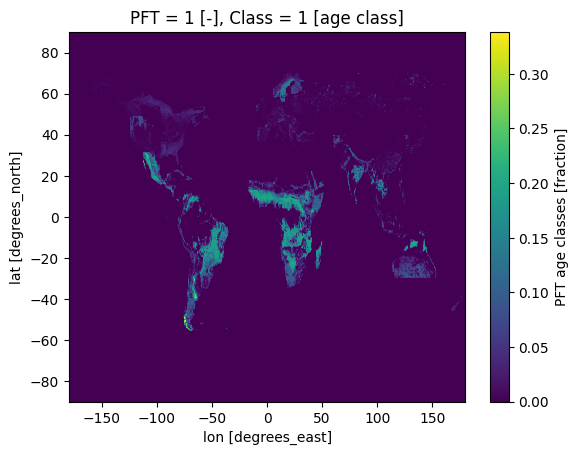

In [5]:
neev_class1.plot()

Now, calculating a weighted average age per forest type.

In [6]:
# 1) Pick midpoints for your 15 bins.
# If you want 5, 15, ..., 145 exactly (as in your example):
mid_age  = np.arange(5, 150, 10, dtype="float32")     # length 15
low_age  = np.arange(1, 150, 10, dtype="float32")     # length 15
high_age = np.arange(10, 150, 10, dtype="float32")     # length 15

# 2) Make a DataArray aligned to the Class dimension
age_mid = xr.DataArray(
    mid_age,
    dims=["Class"],
    coords={"Class": ds["Class"]}   # ensures same indexing as your dataset
)

# 3) Compute weighted mean age per PFT,lat,lon
#    (normalize in case the class probabilities don’t sum exactly to 1)
weights = ds["age"]                 # dims: Class, PFT, lat, lon
w_sum = weights.sum(dim="Class")
mean_age = (weights * age_mid).sum(dim="Class") / w_sum.where(w_sum > 0)

# Result dims: PFT, lat, lon  (one mean age map per PFT)
mean_age


<xarray.DataArray (PFT: 4, lat: 360, lon: 720)> Size: 8MB
dask.array<truediv, shape=(4, 360, 720), dtype=float64, chunksize=(4, 180, 180), chunktype=numpy.ndarray>
Coordinates:
  * PFT      (PFT) int32 16B 1 2 3 4
  * lat      (lat) float64 3kB 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75
  * lon      (lon) float64 6kB -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8

Plotting the results for Needleleaf Evergreeen

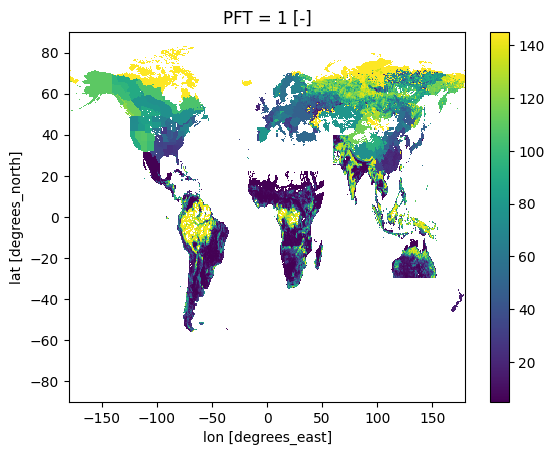

In [7]:
# Example: NEEV = PFT code 1
neev_mean = mean_age.sel(PFT=1)            # 2D (lat, lon)
neev_mean.plot()

Now that each average age has been calculated, this can be use to estimate the age of each of the 16 land uses available. This are stored in UHTH-aligned GeoTIFF for easier computing.

First, opening the grid

In [8]:
# Loading uhth map
uhth_fp = "../data/world_maps/soc_uht_map.tif"
master = rioxarray.open_rasterio(uhth_fp)
master_grid = master.isel(band=0)

Massaging the age data...

In [9]:
# ensuring dims and order
mean_age_2tif = mean_age.transpose("PFT", "lat", "lon")

# rioxarray prefers ascending y/x—keep lat/lon ascending
mean_age_2tif = mean_age_2tif.sortby(["lat", "lon"])

# Rename spatial dims to x/y so rioxarray can’t miss them
mean_age_2tif = mean_age_2tif.rename({"lon": "x", "lat": "y"})

# Assigning a CRS. 
mean_age_2tif = mean_age_2tif.rio.write_crs("EPSG:4326")

# Explicitly set spatial dims (now literally 'x', 'y')
mean_age_2tif = mean_age_2tif.rio.set_spatial_dims(x_dim="x", y_dim="y", inplace=False)

# --- Rename PFT -> band to write a multi-band GeoTIFF
da_mb = mean_age_2tif.rename(PFT="band")

# --- Reproject & snap to the master grid exactly
da_mb_matched = da_mb.rio.reproject_match(master_grid, resampling=Resampling.bilinear)

# Assign no data
da_mb_matched = da_mb_matched.rio.write_nodata(-9999.0)

Now saving

In [10]:
fa_fp = "../data/forest/forest_average_age.tif"

In [11]:
da_mb_matched.rio.to_raster(
        fa_fp,
        dtype="float32",
        compress="lzw",
        predictor=3,   # good for float data with LZW
        tiled=True,
        num_threads="ALL_CPUS"
)

Adding metadata

In [12]:
pft_names = ["NEEV", "NEDE","BREV", "BRDC"]

In [13]:
with rasterio.open(fa_fp, "r+") as dst:
    dst.update_tags(
        TITLE="Mean Forest Age by PFT (years), matched to UHTH grid",
        UNITS="years",
        DESCRIPTION="Probability-weighted mean age per grid cell; multi-band by PFT:  Band 1 - Needleaf evergreen (NEEV), Band 2 - Needleleaf deciduous (NEDE), Band 3 - Broadleaf evergreen (BREV), and Band 4 - broadleaf deciduous (BRDC)",
        METHOD="reproject_match to master grid; bilinear resampling",
        MASTER_REF="soc_uth_map.tif",
    )
    for i, name in enumerate(pft_names, start=1):
        dst.set_band_description(i, f"Mean Forest Age (years) — {name}")
        dst.update_tags(i, units="years")

Checking output

In [14]:
mp.inspect_raster(fa_fp)

File: ../data/forest/forest_average_age.tif
Driver: GTiff
Width, Height: 4320, 2083
Number of Bands: 4
CRS: EPSG:4326
Bounds: BoundingBox(left=-179.99999999999997, bottom=-89.99999999999994, right=179.99999999999991, top=83.58333333333331)
Pixel Size: (0.0833333333333333, 0.0833333333333333)
No-data Value: -9999.0

--- Raster Metadata ---
DESCRIPTION: Probability-weighted mean age per grid cell; multi-band by PFT:  Band 1 - Needleaf evergreen (NEEV), Band 2 - Needleleaf deciduous (NEDE), Band 3 - Broadleaf evergreen (BREV), and Band 4 - broadleaf deciduous (BRDC)
MASTER_REF: soc_uth_map.tif
METHOD: reproject_match to master grid; bilinear resampling
TITLE: Mean Forest Age by PFT (years), matched to UHTH grid
UNITS: years
AREA_OR_POINT: Area

--- Band Information ---

Band 1:
  Data Type: float32
  Min Value: 5.0
  Max Value: 145.0
  Mean Value: 70.4524154663086
  Standard Deviation: 43.89419937133789
  Band Metadata:
    units: years

Band 2:
  Data Type: float32
  Min Value: 5.0
  Max

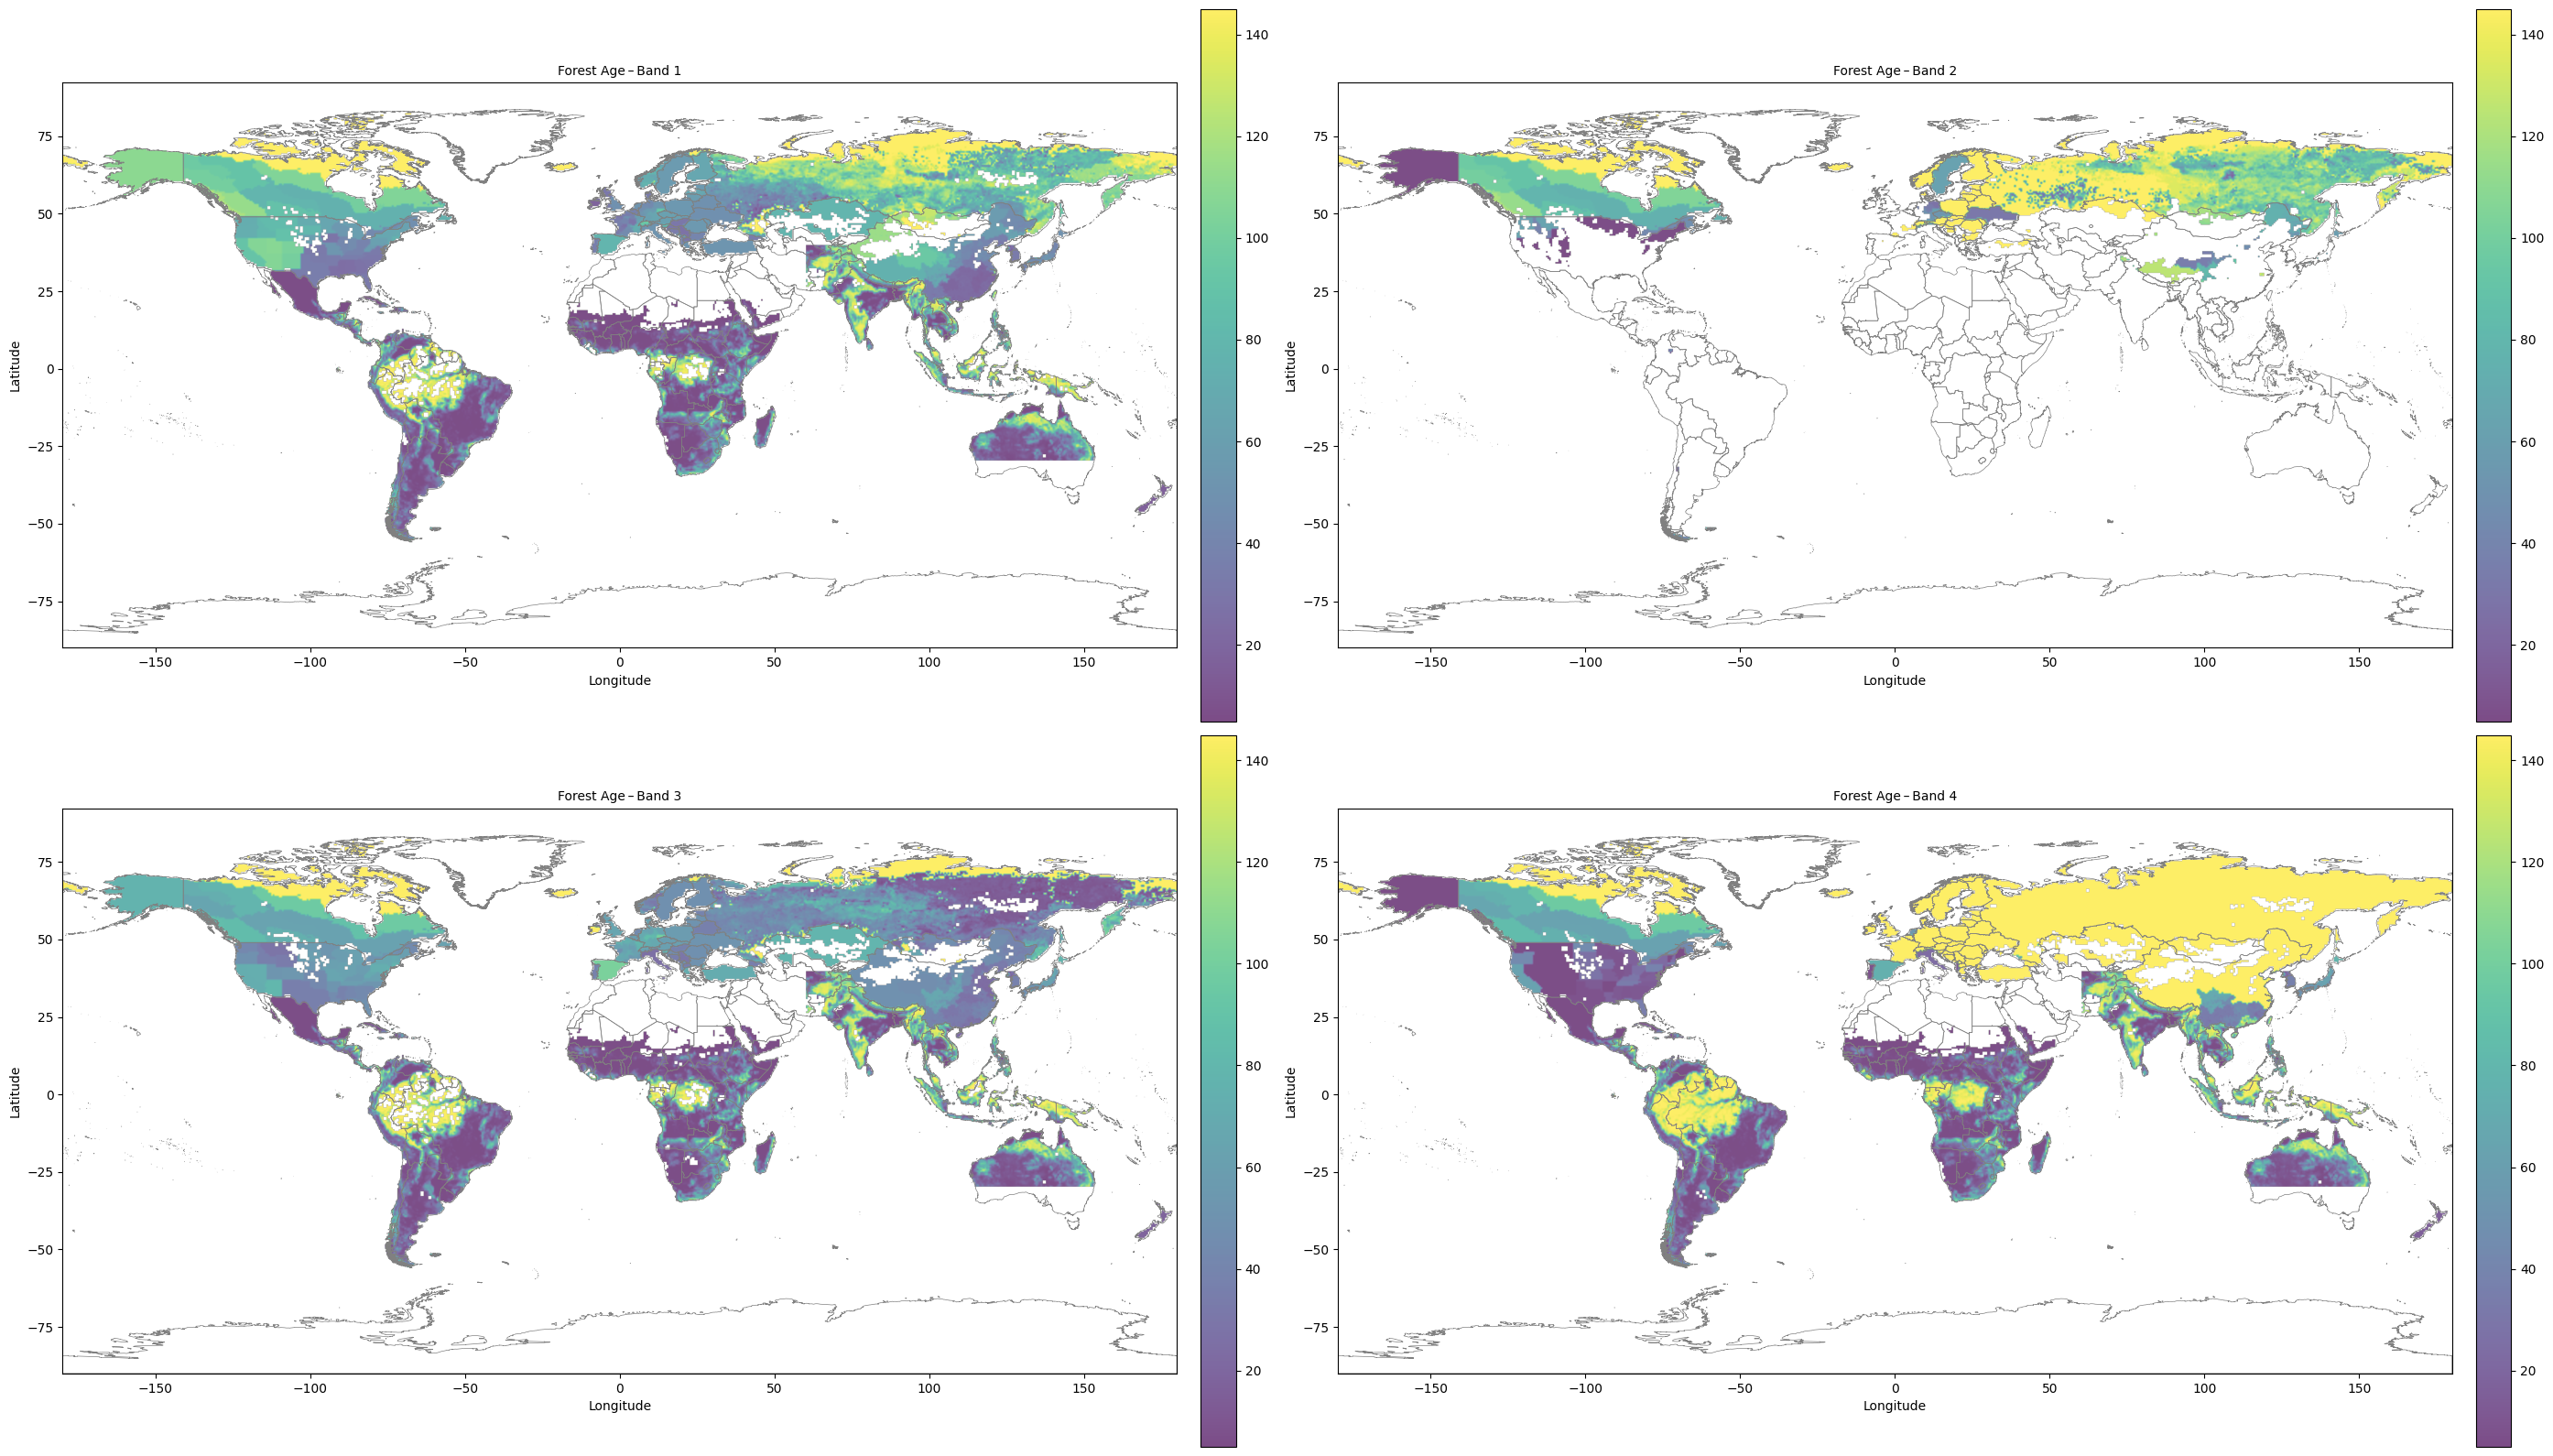

In [15]:
mp.plot_all_raster_bands(fa_fp, "Forest Age", max_cols=2)

#### 1.3 - Assigning Forest Age to Land Uses
Now that average forest age is calculated, this need to be assigned per forest land use.

In [16]:
lu_list = pl.read_excel("../data/crops/lu_c_factor_inventory.xlsx")

In [17]:
forest_lu = lu_list.filter(pl.col("crop_type") == "Forest").select(["land_use", "path"])
forest_lu

land_use,path
str,str
"""Broadleaf_Deciduous_Boreal_dry""","""../data/land_use/lu_Broadleaf_…"
"""Broadleaf_Deciduous_Boreal_moi…","""../data/land_use/lu_Broadleaf_…"
"""Broadleaf_Deciduous_Cold_tempe…","""../data/land_use/lu_Broadleaf_…"
"""Broadleaf_Deciduous_Cold_tempe…","""../data/land_use/lu_Broadleaf_…"
"""Broadleaf_Deciduous_Subtropica…","""../data/land_use/lu_Broadleaf_…"
…,…
"""Needleleaf_Evergreen_Cold_temp…","""../data/land_use/lu_Needleleaf…"
"""Needleleaf_Evergreen_Cold_temp…","""../data/land_use/lu_Needleleaf…"
"""Needleleaf_Evergreen_Subtropic…","""../data/land_use/lu_Needleleaf…"


Now applying a mask of when land use is 1 to the forest age to get the age of each land use

In [18]:
with rasterio.open(fa_fp) as src:
    NEEV_age = src.read(1)
    BRDC_age = src.read(4)
    src_metadata = src.meta.copy()
    age_nodata = src.nodata

In [19]:
for row in forest_lu.iter_rows(named=True):
    lu_name = row["land_use"]
    fp = row["path"]

    print(f"Determining {lu_name} age")

    # loading each land use raster
    with rasterio.open(fp) as src:
        lu_data = src.read(1)
        lu_nodata = src.nodata
        lu_meta = src.meta.copy()

    # creating the land use mask
    mask_lu = (lu_data == 1) & (lu_data != lu_nodata) & ~np.isnan(lu_data)

    # Identifying the age layer
    if "Needleleaf" in lu_name:
        age_data = NEEV_age
    else:
        age_data = BRDC_age

    # Now assigning the age
    lu_age = np.where(mask_lu, age_data, np.nan)

    # Updating metadata
    lu_meta.update(
        {"band": 1,
        "dtype": np.float32,
        "nodata": np.nan}
    )

    # Saving the age layer
    lu_savepath = f"../data/forest/age/{lu_name}_age.tif"
    with rasterio.open(lu_savepath, "w", **lu_meta) as dst:
        dst.write(lu_age, 1)

    print(f"Saving {lu_name} age raster. Next...\n")

print("All done")


Determining Broadleaf_Deciduous_Boreal_dry age
Saving Broadleaf_Deciduous_Boreal_dry age raster. Next...

Determining Broadleaf_Deciduous_Boreal_moist age
Saving Broadleaf_Deciduous_Boreal_moist age raster. Next...

Determining Broadleaf_Deciduous_Cold_temperate_dry age
Saving Broadleaf_Deciduous_Cold_temperate_dry age raster. Next...

Determining Broadleaf_Deciduous_Cold_temperate_moist age
Saving Broadleaf_Deciduous_Cold_temperate_moist age raster. Next...

Determining Broadleaf_Deciduous_Subtropical age
Saving Broadleaf_Deciduous_Subtropical age raster. Next...

Determining Broadleaf_Deciduous_Tropical age
Saving Broadleaf_Deciduous_Tropical age raster. Next...

Determining Broadleaf_Deciduous_Warm_temperate_dry age
Saving Broadleaf_Deciduous_Warm_temperate_dry age raster. Next...

Determining Broadleaf_Deciduous_Warm_temperate_moist age
Saving Broadleaf_Deciduous_Warm_temperate_moist age raster. Next...

Determining Needleleaf_Evergreen_Boreal_dry age
Saving Needleleaf_Evergreen_Bo

Inspecting some of the rasters...

In [20]:
test_fp = "../data/forest/age/Needleleaf_Evergreen_Cold_temperate_moist_age.tif"

In [23]:
mp.inspect_raster(test_fp)

File: ../data/forest/age/Needleleaf_Evergreen_Cold_temperate_moist_age.tif
Driver: GTiff
Width, Height: 4320, 2083
Number of Bands: 1
CRS: EPSG:4326
Bounds: BoundingBox(left=-179.99999999999997, bottom=-89.99999999999994, right=179.99999999999991, top=83.58333333333331)
Pixel Size: (0.0833333333333333, 0.0833333333333333)
No-data Value: nan

--- Raster Metadata ---
AREA_OR_POINT: Area

--- Band Information ---

Band 1:
  Data Type: float32
  Min Value: 6.825618267059326
  Max Value: 145.0
  Mean Value: 82.69522094726562
  Standard Deviation: 24.378032684326172


Raster has 55,168 unique values. Min: 6.83. Max: 145.00
Using quantiles
All positives route (quantiles)


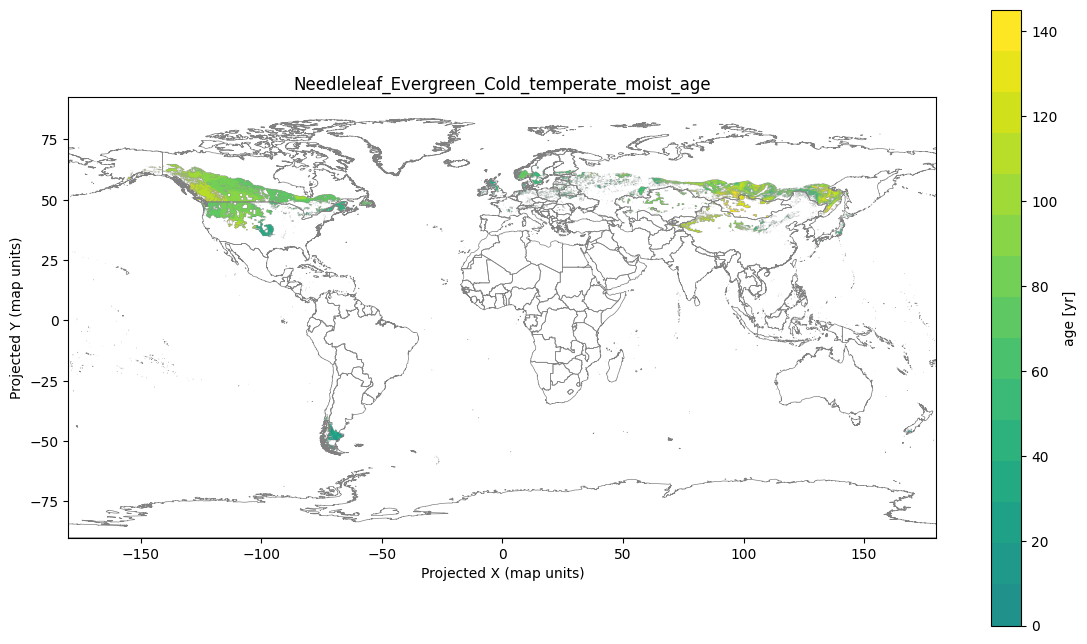

In [25]:
mp.plot_raster_on_world_extremes_cutoff(test_fp, "Needleleaf_Evergreen_Cold_temperate_moist_age", label_title="age [yr]",perc_cutoff=0, quantiles=15)

#### 1.4) Litter calculation
Now that age maps have been generated, litter generation can be calculated. This has been coded under `cropcalcs.get_forest_litter_rate()`, which also assumes that 6 yeas have been added to each pixel age, which assumes that nothing happened between 2010 (the year of the dataset) and 2016 (the year of SOC baseline). 

The following is run as an example:

In [26]:
litter_example_results = cropcalcs.get_forest_litter_rate(test_fp, forest_type="NEEV", weather_type="Cold temperate moist")

Plotting

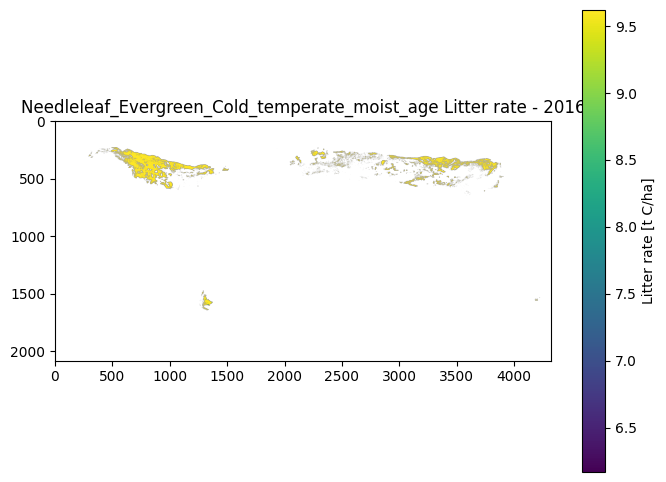

In [27]:
plt.figure(figsize=(8,6))
plt.imshow(np.ma.masked_invalid(litter_example_results), cmap='viridis')  # or 'terrain', 'plasma', etc.
plt.colorbar(label="Litter rate [t C/ha]")
plt.title("Needleleaf_Evergreen_Cold_temperate_moist_age Litter rate - 2016")
plt.show()

# 2 - Run RothC
Testing this for one type of forest (NEEV) for 5 years

In [28]:
import sbtn_leaf.RothC_Raster as rothc

In [29]:
# Extra fp needed
lu_forest_fp = "../data/land_use/lu_Needleleaf_Evergreen_Cold_temperate_moist.tif"
age_fp = "../data/forest/age/Needleleaf_Evergreen_Boreal_moist_age.tif"

In [30]:
forest_soc_test = rothc.run_RothC_forest(
    lu_fp=lu_forest_fp,
    forest_type="NEEV",
    weather_type="Cold temperate moist",
    n_years=5,
    save_folder="../LEAFs",
    age_fp=age_fp,
    evap_fp="../data/soil_weather/uhth_pet_locationonly.tif",
    data_description="Forest Test"
)

Loading environmental data...
Loading forest data...
Running RothC...


C:\Users\loyola\OneDrive - World Wildlife Fund, Inc\Documents\203. Python projects\SBTN_Test\src\sbtn_leaf\RothC_Core.py:69: RuntimeWarning: overflow encountered in exp
  rmf = 47.91 / (np.exp(106.06 / (tmp + 18.27)) + 1.0)
RothC months: 100%|██████████| 60/60 [02:48<00:00,  2.80s/it]


Checking results...

In [31]:
forest_soc_test_fp = '../LEAFs/NEEV_None_5y_SOC.tif'

In [32]:
mp.inspect_raster(forest_soc_test_fp)

File: ../LEAFs/NEEV_None_5y_SOC.tif
Driver: GTiff
Width, Height: 4320, 2083
Number of Bands: 6
CRS: EPSG:4326
Bounds: BoundingBox(left=-179.99999999999997, bottom=-89.99999999999994, right=179.99999999999991, top=83.58333333333331)
Pixel Size: (0.0833333333333333, 0.0833333333333333)
No-data Value: nan

--- Raster Metadata ---
description: Forest Test
long_name: Soil Organic Carbon
model: RothC rasterized vectorized
units: t C/ha
AREA_OR_POINT: Area

--- Band Information ---

Band 1:
  Data Type: float32
  Min Value: 6.81576681137085
  Max Value: 164.99652099609375
  Mean Value: 56.361671447753906
  Standard Deviation: 21.169614791870117

Band 2:
  Data Type: float32
  Min Value: 13.501030921936035
  Max Value: 166.58482360839844
  Mean Value: 61.79985809326172
  Standard Deviation: 20.561397552490234

Band 3:
  Data Type: float32
  Min Value: 20.488723754882812
  Max Value: 168.498046875
  Mean Value: 68.24095153808594
  Standard Deviation: 20.190305709838867

Band 4:
  Data Type: flo

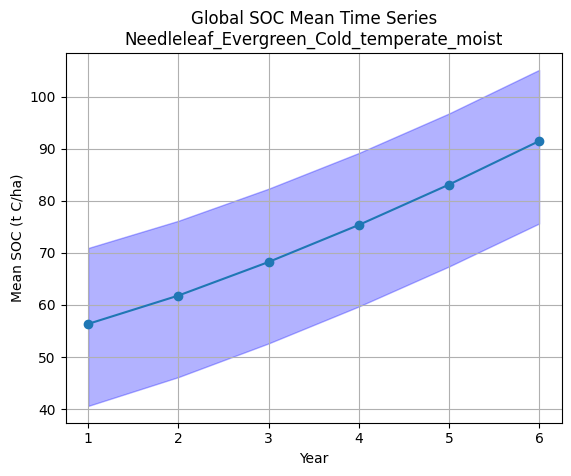

In [33]:
mp.plot_multiband_raster_timesires(forest_soc_test_fp, "Global SOC Mean Time Series\nNeedleleaf_Evergreen_Cold_temperate_moist", show_iq=True)

Raster has 193,550 unique values. Min: 57.95. Max: 133.97
Using quantiles
All positives route (quantiles)


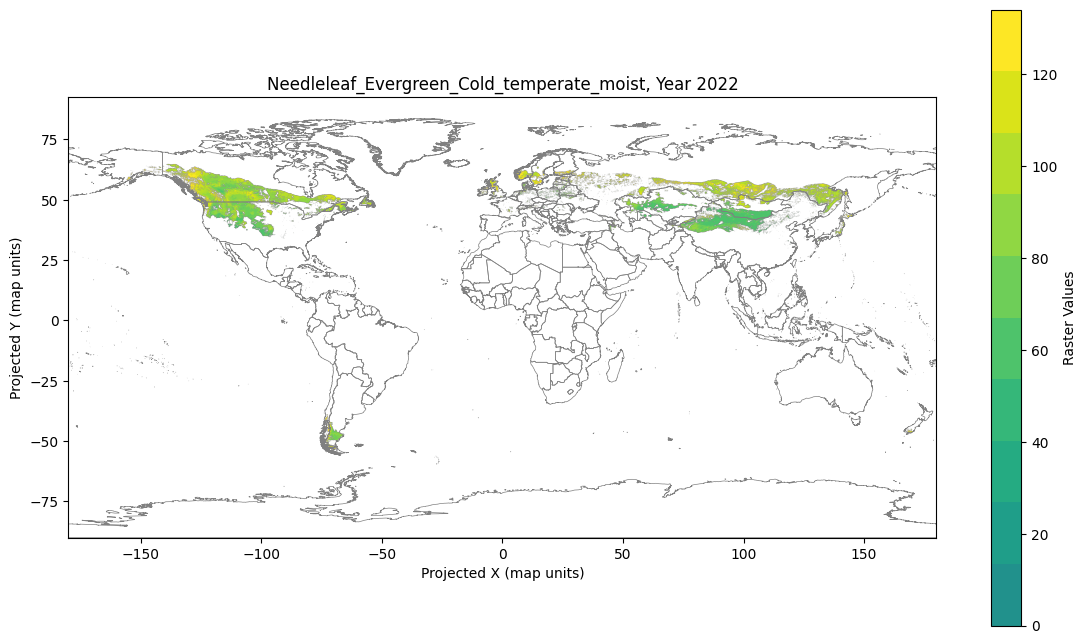

In [36]:
mp.plot_raster_on_world_extremes_cutoff(forest_soc_test_fp, "Needleleaf_Evergreen_Cold_temperate_moist, Year 2022", raster_band=6, perc_cutoff=1, quantiles=10)

In [37]:
pct_change = rothc.calcuate_annual_perc_changes(forest_soc_test_fp)

Raster has 193,210 unique values. Min: 21.78. Max: 204.68
Using quantiles
All positives route (quantiles)


(<Figure size 1400x800 with 2 Axes>,
 <Axes: title={'center': 'SOC Percentage change by year 2022 for\nNeedleleaf_Evergreen_Cold_temperate_moist'}, xlabel='Projected X (map units)', ylabel='Projected Y (map units)'>)

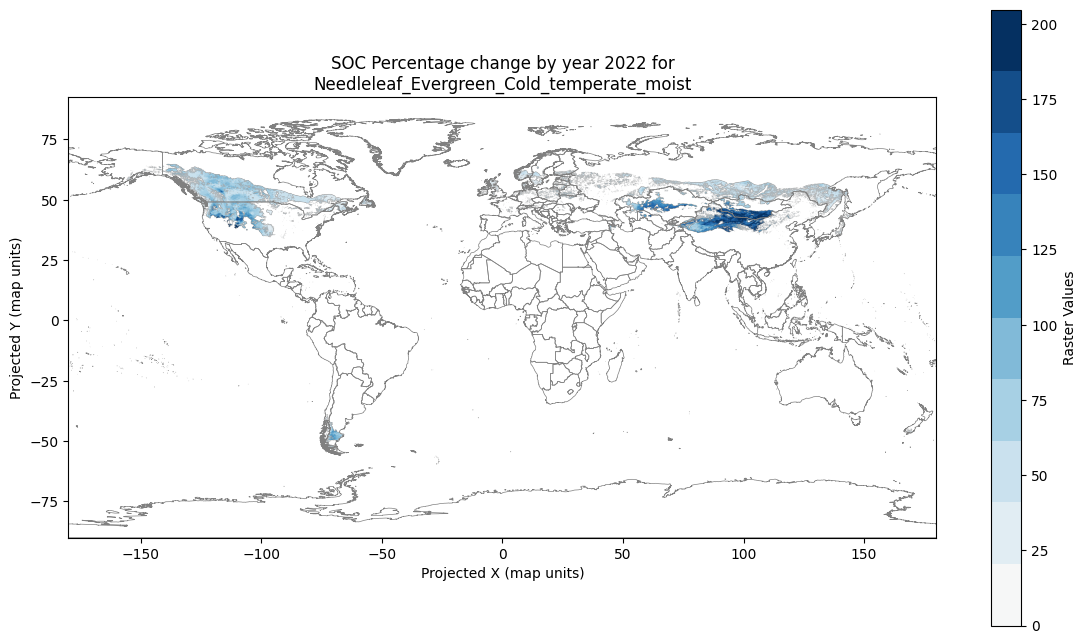

In [38]:
mp.plot_da_on_world_extremes_cutoff(pct_change, "SOC Percentage change by year 2022 for\nNeedleleaf_Evergreen_Cold_temperate_moist", band=5, cmap="RdBu", quantiles=10) # type: ignore